In [45]:
import torch, torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os
import common

In [2]:
# Reproducibility
common.set_seed(156)

In [3]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [4]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())
# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# Point estimate NN
net = NN(28*28, 1024, 10)

In [5]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y)

In [6]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias": pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias": pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [7]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [8]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        for data in train_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            loss += svi.step(images, labels)
        loss /= len(train_loader.dataset)
        print("Epoch %g: Loss = %g" % (epoch, loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [9]:
def load_models(K = 100):
    # Load the models
    sampled_models = [NN(28*28, 1024, 10) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load("model.pt")):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

train_and_save_models(epochs = 10, K = 100, modelname = "model.pt")

In [10]:
sampled_models = load_models(K = 25)

Loaded 25 sample models


## Generate Adversarial Examples

In [47]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())

train, val = random_split(train_dataset,[50000,10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [48]:
# Get a batch and flatten the input
images, targets = next(iter(test_loader))
images = images.reshape(-1, 28*28)

In [49]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [50]:
def otcm(images, eps, saliency):
    return torch.clamp(images.clone()-eps*saliency, 0, 1)

In [51]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, eps, saliency,images):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
        # One step Target Class Method (OTCM); saliency is noise
        new_images = otcm(images, eps, saliency)
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/len(sampled_models)

In [60]:
def generate_saliency(EPS,target,images):
    # Collect noises (saliencies)
    # EPS = 0.18
    saliencies = []
    how_many_fooled = []
    torch.set_printoptions(sci_mode=False)
    # target = torch.tensor([1])
    target = torch.tensor([target])
    for k in range(len(sampled_models)):
        # Forward pass
        # Compute loss w.r.t. an incorrect class
        # Note that we just have to ensure this class is different from targets
        # print("\r Processing " + str(k+1) + "/%s" % len(sampled_models), end="")
        images.grad = None
        images.requires_grad = True
        old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), target])
        # Compute adversarial example
        new_images = otcm(images, EPS, images.grad.sign())
        # Forward pass on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        if old_class != new_class:
            # How many models can this adv. example fool?
            how_many_fooled += [how_many_can_it_fool(sampled_models, EPS, images.grad.sign(), images)]
            saliencies += [images.grad.sign().view(28, 28)]
    # print("\nFinished")
    return saliencies, how_many_fooled
    

In [53]:
def combine_saliencies(saliencies,success):
    # distributional saliency map
    saliencies = torch.stack(saliencies)
    # print(saliencies.shape)
    combined_med  = torch.zeros(28, 28)
    combined_mean = torch.zeros(28, 28)
    for i in range(28):
        for j in range(28):
            # choose median perturbation
            combined_med[i, j] = np.percentile(saliencies[:, i, j].numpy(), 50)
            combined_mean[i, j] = saliencies[:, i, j].mean().item()
    combined_med  = combined_med.flatten()
    combined_mean = combined_mean.flatten()
    champ         = saliencies[success.index(max(success))].flatten()
    return combined_med, combined_mean, champ
    

In [54]:
saliencies, success = generate_saliency(0.18,1, images)


Finished


In [55]:
EPS = .18

In [56]:
combined_med, combined_mean, champ = combine_saliencies(saliencies,success)

In [57]:
print(how_many_can_it_fool(sampled_models, EPS, combined_med,images))
new_images = otcm(images, EPS, combined_med)

0.72


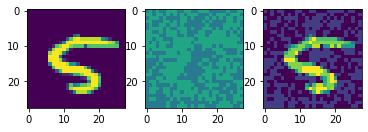

In [58]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((combined_med*EPS).reshape(28, 28).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(28, 28).detach().numpy())
plt.show()

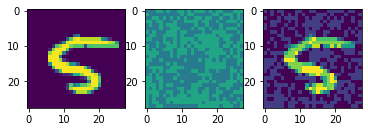

In [59]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((champ*EPS).reshape(28, 28).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(28, 28).detach().numpy())
plt.show()


## Populate Train with Saliency Maps

In [27]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())
# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [140]:
temp_sals, success = generate_saliency(EPS,1,images)

 Processing 25/25
Finished


In [101]:
EPS = 0.18
# for i in range(len(train_dataset.targets)):
target_len = len(train_dataset.classes)
targets    = set(range(10))
counter    = 1 
successes  = []
for data in train_loader:
    images_med   = []
    images_mean  = []
    images_champ = []
    tru_labels   = []
    images, labels = data
    images = images.view(-1, 28*28)
    print("Batch %s" % counter)

    for i in range(images.shape[0]): #
        # the real target
        target_org = labels[i].item() 
        # the target that wanted to be resulted in
        target     = int(np.random.choice(list(targets - set([target_org])),size=1))
        image      = images[i:i+1,:] 
        # generating saliency maps using each sampled network
        temp_sals, success = generate_saliency(EPS,target,image)
        successes.append(success)
        # combining maps into three types
        combined_med, combined_mean, champ = combine_saliencies(temp_sals,success)
        # creating image
        images_med.append(otcm(image, EPS, combined_med))
        images_mean.append(otcm(image, EPS, combined_mean))
        images_champ.append(otcm(image, EPS, champ))
        tru_labels.append(target_org)
    tru_labels   = torch.tensor(tru_labels)
    images_med   = torch.vstack(images_med).reshape(-1,28, 28)
    images_mean  = torch.vstack(images_mean).reshape(-1,28, 28)
    images_champ = torch.vstack(images_champ).reshape(-1,28, 28)
    images_med   = {'images': images_med,  'labels': tru_labels}
    images_mean  = {'images': images_mean, 'labels': tru_labels}
    images_champ = {'images': images_champ,'labels': tru_labels}
    
    
    with open('images_med_%s.pickle' % counter, 'wb') as handle:
        pickle.dump(images_med, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('images_mean_%s.pickle' % counter, 'wb') as handle:
        pickle.dump(images_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('images_champ_%s.pickle' % counter, 'wb') as handle:
        pickle.dump(images_champ, handle, protocol=pickle.HIGHEST_PROTOCOL)
    counter += 1 
    if counter > 8:
        break


Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8


## Training BNN with Adversarial Examples

In [153]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())

# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### loading adversarial examples

In [154]:
dirs = [d for d in os.listdir(".") if "images_med" in d]

images  = []
targets = []
for d in dirs:
    with open(d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images).int()
targets = torch.hstack(targets)

In [155]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

In [156]:
train, val = random_split(train_dataset,[51024,10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [162]:
def train_adversarial(epochs = 10, K = 100, modelname = "AdvBNN.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        for data in train_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            loss  += svi.step(images, labels)
        loss /= len(train_loader.dataset)
        # model.eval()     # Optional when not using Model Specific layer
        val_loss = 0.
        for data in val_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            val_loss += svi.evaluate_loss(images, labels)
        val_loss /= len(val_loader.dataset)
        print("Epoch %g: Loss = %g: Val_Loss = %g" % (epoch, loss,val_loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [163]:
train_adversarial()

Epoch 0: Loss = 72.8608: Val_Loss = 70.427
Epoch 1: Loss = 68.552: Val_Loss = 67.6154
Epoch 2: Loss = 66.6034: Val_Loss = 66.389
Epoch 3: Loss = 65.7868: Val_Loss = 66.6741
Epoch 4: Loss = 65.8724: Val_Loss = 66.3151
Epoch 5: Loss = 65.568: Val_Loss = 66.1872
Epoch 6: Loss = 65.6789: Val_Loss = 66.2749
Epoch 7: Loss = 65.6447: Val_Loss = 66.4574
Epoch 8: Loss = 65.7479: Val_Loss = 66.6923
Epoch 9: Loss = 65.6441: Val_Loss = 66.1903
Saved 100 models
